In [ ]:
import os
import gc
import contextlib
import itertools
import pickle
import lime
import tensorflow               as tf
import matplotlib.pyplot        as plt
import numpy                    as np
import seaborn                  as sns
from sklearn.metrics.pairwise   import cosine_similarity
from skimage.segmentation       import mark_boundaries
from lime                       import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm


In [3]:
test_dataset = tf.data.Dataset.load('test_dataset')
test_dataset = test_dataset.shuffle(64)

2024-10-22 20:03:43.790364: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
test_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

(64, 32, 32, 3)
(64, 10)
Normalized values:  (0.0, 0.9963082)


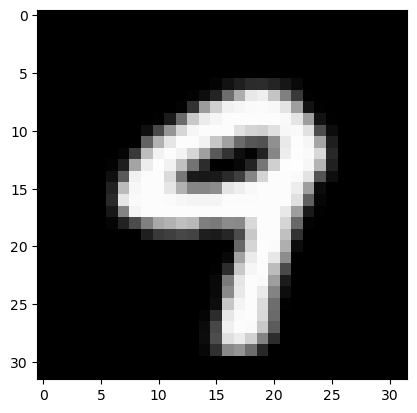

In [5]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img = np.array(img_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])

In [ ]:
models_extrcs = []

saved_dir       = "models/diff_encoders"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_extrcs.append(model)

In [ ]:
for model_file in models_extrcs:
    print(model_file.name)

MobileNetV2_MNIST
CNN_MNIST
Densenet121-MNIST
EfficientNet-MNIST


In [8]:
import helper_functions

sample_lists = [helper_functions.get_sample(i, test_dataset) for i in range(10)]

In [ ]:
# filter out samples that got predicted wrong
preds_encods = [helper_functions.get_predictions(models_extrcs, sample_list) for sample_list in sample_lists]
newlists     = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_encods]

Wrong Prediction at index 8 by MobileNetV2_MNIST: Predicted [6], True 0
Wrong Prediction at index 131 by MobileNetV2_MNIST: Predicted [2], True 0
Wrong Prediction at index 26 by MobileNetV2_MNIST: Predicted [8], True 1
Wrong Prediction at index 164 by Densenet121-MNIST: Predicted [6], True 1
Wrong Prediction at index 34 by EfficientNet-MNIST: Predicted [1], True 2
Wrong Prediction at index 54 by MobileNetV2_MNIST: Predicted [8], True 2
Wrong Prediction at index 67 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 139 by EfficientNet-MNIST: Predicted [3], True 2
Wrong Prediction at index 180 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 7 by CNN_MNIST: Predicted [7], True 3
Wrong Prediction at index 9 by Densenet121-MNIST: Predicted [8], True 3
Wrong Prediction at index 90 by MobileNetV2_MNIST: Predicted [5], True 3
Wrong Prediction at index 23 by Densenet121-MNIST: Predicted [9], True 4
Wrong Prediction at index 49 by EfficientNet-MNIST: Predicted [9], True 

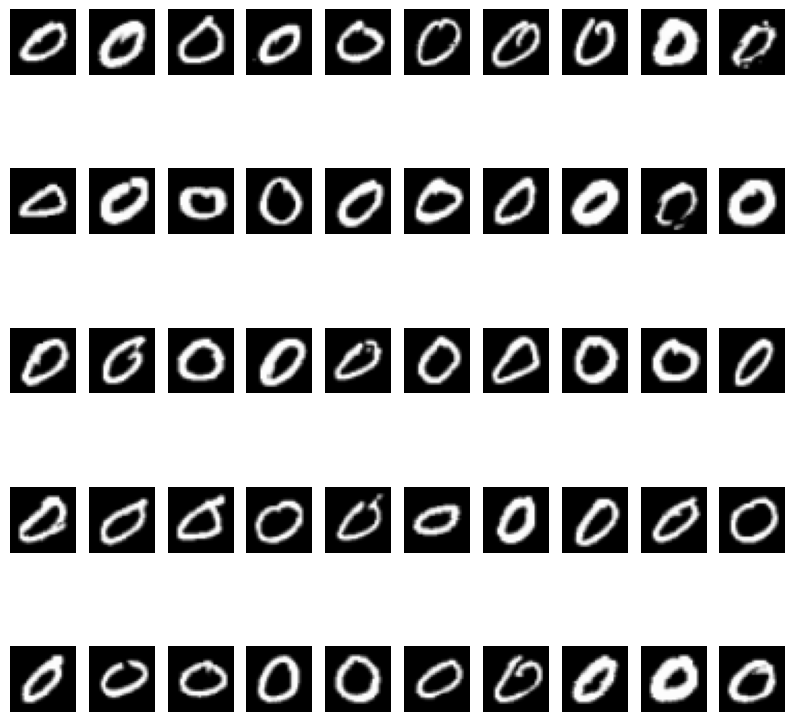

In [9]:
plt.figure(figsize=(10,10))

for index, (image, label) in enumerate(newlists[0][:50]):
    plt.subplot(5,10, index + 1)
    plt.imshow(image.numpy().astype('double'))
    plt.axis('off')

In [11]:
for ls in newlists:
    print(len(ls))

205
228
193
204
187
166
199
209
184
187


In [12]:
import LIME
import importlib
importlib.reload(LIME)

<module 'LIME' from '/home/s2310144/workshop/Underspecification/mnist/LIME.py'>

Iteration : 1


  0%|          | 0/300 [00:00<?, ?it/s]

Predicted Class : 0
Explaining Class: 0
Iteration : 2


  0%|          | 0/300 [00:00<?, ?it/s]

Predicted Class : 0
Explaining Class: 0


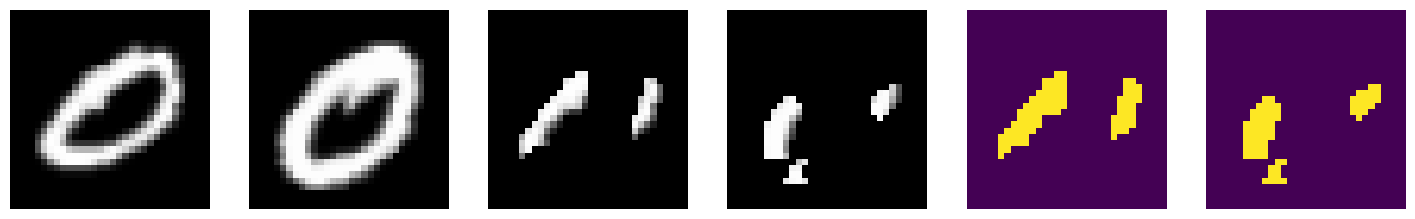

In [ ]:
from LIME import explanation_fn

temps, masks, expls = explanation_fn(newlists[0][:2], models_extrcs[0], 300)

plt.figure(figsize=(18, 6))  
for idx, (img, lbl) in enumerate(newlists[0][:2]):
    plt.subplot(1,6 , idx + 1)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')

for i, item in enumerate(temps):
    plt.subplot(1, 6, i + 3)
    plt.imshow(item)
    plt.axis('off')

for i, item in enumerate(masks):
    plt.subplot(1, 6, i + 5)
    plt.imshow(item)
    plt.axis('off')

plt.show()

In [ ]:
%%time
save_directory = "LIME_expls/diff_extrcs"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_expls(newlists, models_extrcs, 1000, save_directory)

In [ ]:
with open('LIME_expls/diff_extrcs/explain_0_CNN_MNIST.pkl', 'rb') as file:
    explain0_cnn = pickle.load(file)
    
print(len(explain0_cnn))
# temp, mask, expl = explain0_cnn

# for i, img in enumerate(mask[:2]):
#     plt.subplot(1,2, i+1)
#     plt.imshow(img)
#     plt.axis('off')

3


In [ ]:
with open('LIME_expls/diff_extrcs/explain_0_MobileNetV2_MNIST.pkl', 'rb') as file:
    explain0_mbnet = pickle.load(file)

temp, mask, expl = explain0_mbnet

# for i, img in enumerate(mask):
#     plt.subplot(1,2, i+1)
#     plt.imshow(img)
#     plt.axis('off')

50


In [7]:
models_opts = []

saved_dir = "models/diff_optimizers"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_opts.append(model)

In [13]:
for model in models_opts:
    print(model.name)

CNN-MNIST-Adam
CNN_MNIST-SGD
CNN-MNIST-RMSprop
CNN-MNIST-Nadam


In [12]:
# filter out samples (take only correctly predicted samples) for models with different optimizers
preds_opts    = [helper_functions.get_predictions(models_opts, sample_list) for sample_list in sample_lists]
newlists_opts = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_opts]

Wrong Prediction at index 49 by CNN-MNIST-RMSprop: Predicted [7], True 0
Wrong Prediction at index 87 by CNN-MNIST-Nadam: Predicted [8], True 0
Wrong Prediction at index 141 by CNN-MNIST-Nadam: Predicted [2], True 0
Wrong Prediction at index 16 by CNN_MNIST-SGD: Predicted [7], True 2
Wrong Prediction at index 33 by CNN-MNIST-Nadam: Predicted [8], True 2
Wrong Prediction at index 117 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 140 by CNN-MNIST-RMSprop: Predicted [8], True 2
Wrong Prediction at index 157 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 27 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 100 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 61 by CNN-MNIST-Adam: Predicted [9], True 4
Wrong Prediction at index 91 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong Prediction at index 167 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong Prediction at index 185 by CNN_MNIST-SGD: Predicted [6], True 4
Wron

In [ ]:
%%time
import LIME

save_directory = "LIME_expls/diff_optimizers"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_expls(newlists_opts, models_opts, 1000, save_directory)

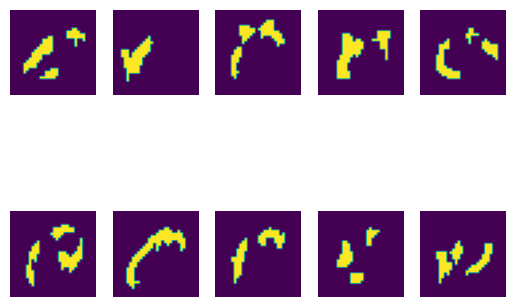

In [52]:
with open("LIME_expls/diff_optimizers/explain_0_CNN_MNIST-SGD.pkl", "rb") as file:
    expl_sgd = pickle.load(file)

temp_sgd, mask_sgd, _ = expl_sgd

for i, mask in enumerate(mask_sgd[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mask)
    plt.axis('off')

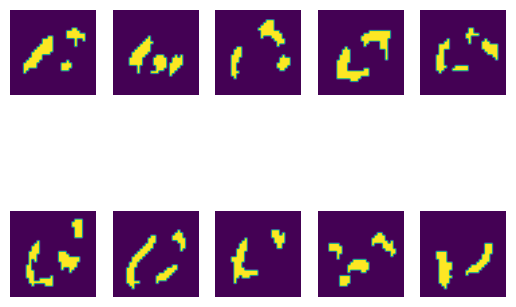

In [54]:
with open("LIME_expls/diff_optimizers/explain_0_CNN-MNIST-Adam.pkl", "rb") as file:
    expl_adam = pickle.load(file)

temp_adam, mask_adam, _ = expl_adam

for i, mask in enumerate(mask_adam[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mask)
    plt.axis('off')

In [18]:
models_seeds = []

saved_dir    = "models/diff_seeds"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_seeds.append(model)

In [19]:
for i, model in enumerate(models_seeds):
    model._name = f"CNN{i+1}"
    print(model.name)

CNN1
CNN2
CNN3
CNN4
CNN5
CNN6
CNN7
CNN8
CNN9
CNN10


In [20]:
# filter out samples (take only correctly predicted samples) for models with different optimizers
preds_seeds    = [helper_functions.get_predictions(models_seeds, sample_list) for sample_list in sample_lists]
newlists_seeds = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_seeds]

Wrong Prediction at index 49 by CNN2: Predicted [6], True 0
Wrong Prediction at index 87 by CNN2: Predicted [6], True 0
Wrong Prediction at index 117 by CNN5: Predicted [6], True 0
Wrong Prediction at index 141 by CNN1: Predicted [2], True 0
Wrong Prediction at index 16 by CNN3: Predicted [7], True 2
Wrong Prediction at index 37 by CNN3: Predicted [7], True 2
Wrong Prediction at index 117 by CNN5: Predicted [7], True 2
Wrong Prediction at index 140 by CNN9: Predicted [8], True 2
Wrong Prediction at index 157 by CNN3: Predicted [7], True 2
Wrong Prediction at index 174 by CNN3: Predicted [7], True 2
Wrong Prediction at index 27 by CNN2: Predicted [5], True 3
Wrong Prediction at index 36 by CNN10: Predicted [7], True 3
Wrong Prediction at index 100 by CNN2: Predicted [5], True 3
Wrong Prediction at index 58 by CNN3: Predicted [1], True 4
Wrong Prediction at index 61 by CNN3: Predicted [9], True 4
Wrong Prediction at index 91 by CNN6: Predicted [9], True 4
Wrong Prediction at index 92 by 

In [ ]:
%%time
save_directory = "LIME_expls/diff_seeds"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_expls(newlists_seeds, models_seeds, 1000, save_directory)